## A Modified Lotka-Volterra Model with Diffusion
The following two differential equations are used to describe...
$$\begin{cases} 
\begin{eqnarray}
    \frac{\partial u}{\partial t} &=& ru(1 - \frac{u}{K}) - muv + D_u \Delta u \\
    \frac{\partial v}{\partial t} &=& -sv + pmuv + D_v \Delta v
\end{eqnarray}
\end{cases}$$
I will simulate this system on domain $E = [-1,1]$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def log(U,V):
    f = open("log.txt", "a")
    f.write("Now:" + np.array2string(U) + "\n" + np.array2string(V))

Let's define system parameters:

In [37]:
#args = (r, K, m, s, p, D_u, D_v)
args = (0.7,100,0.8,0.3,0.2,5.,10.)
r, K, m, s, p, D_u, D_v = args

We discretize time and space. The time step dt must be small enough to ensure the stability of the numerical simulation:

In [42]:
R = 25.0  #prev = 100.
L = -25.0 #prev = -100.
size = int((R-L)/2*10)  # size of the 1D grid 
dx = (R - L) / size  # space step = (R - L) / size
T = 3.  # total time  prev = 9.
dt = .001  # time step  prev = 0.0001
n = int(T / dt)  # number of iterations
P = lambda Delta: dt * (r*U*(1-np.divide(U,K))-m*U*V+D_u*Delta)
Q = lambda Delta: dt * (-s*V+p*m*U*V+D_v*Delta)

We initialize the variables u and v. The matrices U and V contain the values of these variables on the vertices of the 2D grid. These variables are initialized with a uniform noise between 0 and 1:

In [43]:
def get_initial(size):
    '''get initial values in matrices'''
    territory = np.linspace(L,R, size, dtype = np.float128)
    phi_U = lambda x: K/2/np.sqrt(2*np.pi) * np.exp(-(x-3)**2/10)  # half of environment 
    phi_V = lambda x: 10./np.sqrt(2*np.pi) * np.exp(-(x+2)**2/10)
    U = phi_U(territory)
    V = phi_V(territory)
    
    return U.reshape(-1,1), V.reshape(-1,1)

Now let's define discrete Laplace operator of a 1D variable on the grid. By definition, with small $h$:
$$ \Delta u = \frac{u(x+\delta x) + u(x-\delta x) - 2u(x)}{\delta x^2} $$

In [44]:
def discrete_laplacian(M):
    '''discrete laplace operator'''
    L = -2*M
    L += np.roll(M, -1)  # +dx
    L += np.roll(M, 1)  # -dx
    return np.divide(L,dx**2)

In [45]:
def show_patterns1D(U,V, ax=None):
    x = np.linspace(L,R,size)
    ax.plot(x,U, color = 'blue', label='prey')
    ax.plot(x,V, color = 'red', label='predator')

We update by next rule:
$$\begin{cases} 
\begin{eqnarray}
    u(t+\delta t) &=& u + \delta t(ru(1 - \frac{u}{K}) - muv + D_u \Delta u) \\
    v(t+\delta t) &=& v + \delta t(-sv + pmuv + D_v \Delta v)
\end{eqnarray}
\end{cases}$$ 

In [46]:
def update(U,V, func = discrete_laplacian ):
    '''update values of U and V matrices w.r.t. time variable'''
    dU = func(U)  # get \Delta U
    dV = func(V)  # get \Delta V
    
    diffU = P(dU)
    diffV = Q(dV)
    
    log(U,V)  # logging data
    
    U += diffU
    V += diffV
    
    return U,V

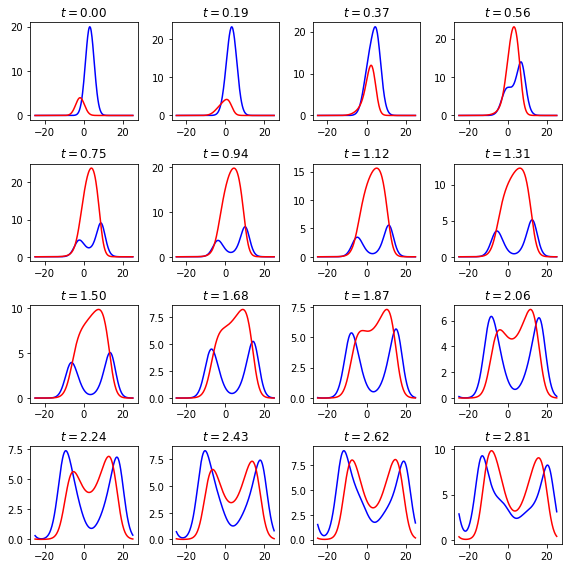

In [47]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
step_plot = n // 16

U,V = get_initial(size)

import os
os.remove("log.txt")  # rewrite log file to get rid of prev launches

for i in range(n):
    # Plot the state of the system at
    # 9 different times.
    if i % step_plot == 0 and i < 16 * step_plot:
        ax = axes.flat[i // step_plot]
        show_patterns1D(U,V, ax=ax)
        ax.set_title(f'$t={i * dt:.2f}$')
        plt.tight_layout()
    
    U,V = update(U,V)

### 2D model

We initialize the variables u and v. The matrices U and V contain the values of these variables on the vertices of the 2D grid. These variables are initialized with a uniform noise between 0 and 1:

In [21]:
def get_initial_2D(size):
    territory = np.linspace(L,R, size, dtype = np.float128)
    phi_U = lambda x,y: K/2/np.sqrt(2*np.pi) * np.exp(-(x**2+y**2)/10)  # half of environment 
    phi_V = lambda x,y: 1/np.sqrt(2*np.pi) * np.exp(-(x**2+y**2)**2/10)
    U = np.array([phi_U(x,y) for x in territory for y in territory], dtype = np.float64).reshape(size,-1)
    V = np.array([phi_V(x,y) for x in territory for y in territory], dtype = np.float64).reshape(size,-1)
    '''
    U = np.random.rand(size, size)
    V = np.random.rand(size, size)
    '''
    return U,V

In [224]:
V = get_initial_2D(100)[1]
V.shape

(100, 100)

Now, we define a function that computes the discrete Laplace operator of a 2D variable on the grid, using a five-point stencil finite difference method. This operator is defined by:
$$ \Delta u(x,y) \simeq \frac{u(x+h,y)+u(x-h,y)+u(x,y+h)+u(x,y-h)-4u(x,y)}{dx^2} $$
We can compute the values of this operator on the grid using vectorized matrix operations. Because of side effects on the edges of the matrix, we need to remove the borders of the grid in the computation:

In [20]:
def discrete_laplacian_2D(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return L

We define a function that displays the matrix:

In [226]:
def draw(A,B):
    """draw the concentrations"""
    fig, ax = plt.subplots(1,2,figsize=(5.65,4))
    ax[0].imshow(A, cmap='Greys')
    ax[1].imshow(B, cmap='Greys')
    ax[0].set_title('A')
    ax[1].set_title('B')
    ax[0].axis('off')
    ax[1].axis('off')

"def show_patterns(U, ax=None):\n    ax.imshow(U, cmap=plt.cm.copper,\n              interpolation='bilinear',\n              extent=[-1, 1, -1, 1])\n    ax.set_axis_off()\n"

Now, we simulate the system of equations using the finite difference method. At each time step, we compute the right-hand sides of the two equations on the grid using discrete spatial derivatives (Laplacians). Then, we update the variables using a discrete time derivative. We also show the evolution of the system at 9 different steps:

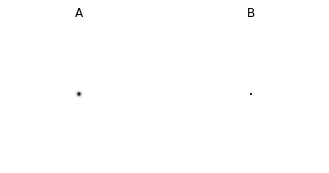

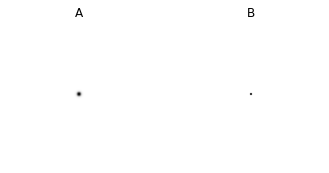

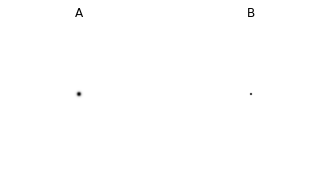

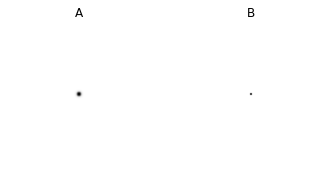

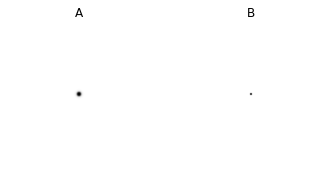

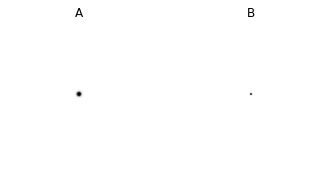

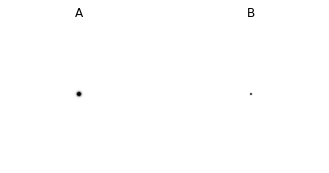

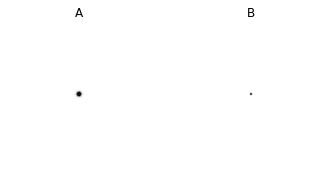

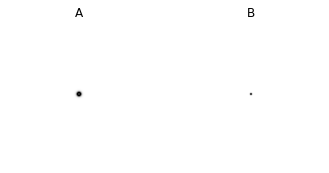

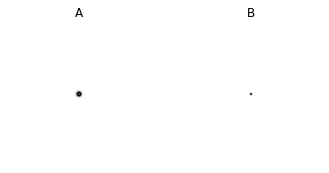

In [239]:
# We simulate the PDE with the finite difference
# method.
U,V = get_initial_2D(size)
for i in range(n):
    U,V = update(U,V,discrete_laplacian_2D)
    draw(U,V)

#### Animation

In [16]:
import matplotlib as mpl
import matplotlib.animation as animation  # this is needed for the animation API
from matplotlib.colors import Normalize   # this is needed to rescale the color during the simulation

In [17]:
def get_artists(U,V):
    """draw the concentrations"""
    fig, ax = plt.subplots(1,2,figsize=(5.65,3))
    imU = ax[0].imshow(U, animated=True, cmap='inferno')
    imV = ax[1].imshow(V, animated=True, cmap='PRGn')
    ax[0].set_title('U')
    ax[1].set_title('V')
    ax[0].axis('off')
    ax[1].axis('off')
    
    return fig, imU, imV

In [18]:
def updatefig(frame_id,updates_per_frame,U,V,discrete_laplacian_2D):
    """Takes care of the matplotlib-artist update in the animation"""
    global imU, imV
    
    args = (1.7,100,1.8,2.3,1.2,3.,4.)
    r, K, m, s, p, D_u, D_v = args

    # update x times before updating the frame
    for u in range(updates_per_frame):
        U,V = update(U,V, discrete_laplacian_2D)

    # update the frame
    imU.set_array(U)
    imV.set_array(V)

    # renormalize the colors
    imU.set_norm(Normalize(vmin=np.amin(U),vmax=np.amax(U)))
    imV.set_norm(Normalize(vmin=np.amin(V),vmax=np.amax(V)))

    # return the updated matplotlib objects
    return imU, imV

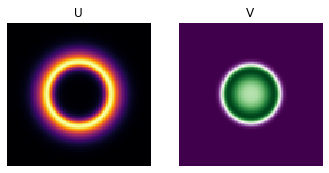

In [40]:
args = (2.7,100,0.4,1.5,1.2,5.,10.)
r, K, m, s, p, D_u, D_v = args
R = 10.0  #prev = 100.
L = -10.0 #prev = -100.
size = int((R-L)/2*10)  # size of the 1D grid 
dx = (R - L) / size  # space step = (R - L) / size
U,V = get_initial_2D(size)
fig, imU, imV = get_artists(U,V)
updates_per_frame = 10
animation_arguments = (updates_per_frame, U,V,discrete_laplacian_2D,)
T = 1.  # total time
dt = .0001  # time step
n = int(T / dt)  # number of iterations
# let's make sure we can see the animation in the notebook
from IPython.display import HTML
mpl.rcParams['animation.html'] = 'html5'
#mpl.rcParams['animation.embed_limit'] = 1024 # this allows jupyter notebook to save 1024MB video data in the memory

# start the animation
ani = animation.FuncAnimation(fig, #matplotlib figure
                              updatefig, # function that takes care of the update
                              fargs=animation_arguments, # arguments to pass to this function
                              interval=10, # update every `interval` milliseconds
                              frames=int(n/updates_per_frame), #limit the number of frames
                              blit=True, # optimize the drawing update
                              )

HTML(ani.to_html5_video())